In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
try:
    import _pickle as cPickle
except:
    import cPickle
import cv2
import tensorflow as tf
import os, time, sys, math, random
from IPython.display import display, clear_output

In [3]:
import matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(length):
    initial = tf.constant(0.1, shape=[length], dtype=tf.float32)
    return tf.Variable(initial)

In [5]:
def createConvulationalLayer(input_data, channel_count, filter_size, filter_count, max_pooling=True):
    shape = [filter_size, filter_size, channel_count, filter_count]
    weights = weight_variable(shape=shape)
    bias = bias_variable(length=filter_count)
    layer = tf.nn.conv2d(input=input_data,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += bias
    if max_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        layer = tf.layers.dropout(layer, rate=0.25)
    layer = tf.nn.relu(layer)
    return layer, weights

In [6]:
def createFlattenLayer(layer):
    layer_shape = layer.get_shape()
    # layer_shape is assumed to be in shape [number_of_images, image_height, image_width, channels]
    # The channels will be the number of fiter_count in the previous layer
    feature_count = layer_shape[1:4].num_elements()
    # layer_shape[1:4].num_elements()
    flat_layer = tf.reshape(layer, [-1, feature_count])
    return flat_layer, feature_count

In [7]:
def createFullyConnectedLayer(input_data, input_feature_count, output_feature_count, apply_relu=False):
    weights = weight_variable(shape=[input_feature_count, output_feature_count])
    bias = bias_variable(length=output_feature_count)
    layer = tf.matmul(input_data, weights) + bias
    if apply_relu:
        layer = tf.nn.relu(layer)
    return layer

In [8]:
def splitFilenameAndAngle(row):
    filename_and_angle = row.strip().split(',')[0].split()
    result = [filename_and_angle[0], (float(filename_and_angle[1]) * math.pi) / 180]
    return result

In [9]:
def readDataSetInfo(dataset_id='01'):
    info_data = ''
    info_data_dict = {}
    dataset_path = os.path.join('data', 'dataset_' + dataset_id)
    info_file_path = os.path.join(dataset_path, 'data.txt')
    xs = []
    ys = []
    with open(info_file_path, 'r') as f:
        for line in f.readlines():
            filename_and_angle = line.strip().split(',')[0].split()
            x, y = filename_and_angle[0], (float(filename_and_angle[1]) * math.pi) / 180
            xs.append(x)
            ys.append(y)
    
    together = list(zip(xs, ys))
    
    random.shuffle(together)
    filenames, angles = zip(*together)
    
    info_data_dict['path'] = dataset_path
    info_data_dict['filenames'] = filenames
    info_data_dict['angles'] = angles
    return info_data_dict

In [10]:
def readImages(dataset_info, limit=10000, batch_size=40):
    image_data_list = []
    rotation_data_list = []
    for index, filename in enumerate(dataset_info['filenames']):
        image_path = os.path.join(data_info['path'], 'images', filename)
        image_data = cv2.imread(image_path)
        image_data = cv2.resize(image_data, (0,0), fx=0.4, fy=0.4)
        image_data_list.append(image_data)
        rotation_data_list.append(dataset_info['angles'][index])
        if len(image_data_list) == batch_size:
            if batch_size == 1:
                image_data_list, rotation_data_list = image_data_list[0], rotation_data_list[0]
            yield np.array(image_data_list), np.array(rotation_data_list).reshape(-1, 1)
            image_data_list = []
            rotation_data_list = []
        
    if image_data_list:
        yield np.array(image_data_list), np.array(rotation_data_list).reshape(-1, 1)

In [11]:
def preprocessData(x):
    mu = np.mean(x, axis=(0, 1, 2), keepdims=1)
    sigma = np.std(x, axis=(0, 1, 2), keepdims=1)
    x = x - mu
    x = x / sigma
    return x

In [12]:
data_info = readDataSetInfo()

In [13]:
a = None
b = None
for x, y in readImages(data_info):
    a = preprocessData(x)
    b = y
    break

In [14]:
a.shape

(40, 102, 182, 3)

In [15]:
sample_image, sample_rotation = readImages(data_info, batch_size=1).next()
# plt.imshow(a[3])

In [16]:
sample_image.shape

(102, 182, 3)

In [17]:
image_height = sample_image.shape[0]
image_width = sample_image.shape[1]
image_depth = sample_image.shape[2]

In [18]:
image_height * image_width * image_depth

55692

In [19]:
filter_size_2 = 2
filter_size_3 = 3
filter_size_5 = 5
filter_count_24 = 24
filter_count_32 = 32
filter_count_36 = 36
filter_count_48 = 48
filter_count_64 = 64
filter_count_128 = 128

fully_conn_layer_1_out_size = 100
fully_conn_layer_2_out_size = 50
fully_conn_layer_3_out_size = 10
fully_conn_layer_4_out_size = 1

In [20]:
x = tf.placeholder(tf.float32, shape=[None, image_height, image_width, image_depth])
y_actual = tf.placeholder(tf.float32, shape=(None, 1))

In [21]:
conv_layer_1, conv_weights_1 = createConvulationalLayer(input_data=x,
                   channel_count=image_depth,
                   filter_size=filter_size_5,
                   filter_count=filter_count_24,
                   max_pooling=False)

In [22]:
conv_layer_2, conv_weights_2 = createConvulationalLayer(input_data=conv_layer_1,
                   channel_count=filter_count_24,
                   filter_size=filter_size_5,
                   filter_count=filter_count_36,
                   max_pooling=True)

In [23]:
conv_layer_3, conv_weights_3 = createConvulationalLayer(input_data=conv_layer_2,
                   channel_count=filter_count_36,
                   filter_size=filter_size_5,
                   filter_count=filter_count_48,
                   max_pooling=False)

In [24]:
conv_layer_4, conv_weights_4 = createConvulationalLayer(input_data=conv_layer_3,
                   channel_count=filter_count_48,
                   filter_size=filter_size_3,
                   filter_count=filter_count_64,
                   max_pooling=True)

In [25]:
conv_layer_5, conv_weights_5 = createConvulationalLayer(input_data=conv_layer_4,
                   channel_count=filter_count_64,
                   filter_size=filter_size_3,
                   filter_count=filter_count_64,
                   max_pooling=False)

In [26]:
flat_layer, num_features = createFlattenLayer(conv_layer_5)

In [27]:
fully_con_layer_1 = createFullyConnectedLayer(input_data=flat_layer,
                         input_feature_count=num_features,
                         output_feature_count=fully_conn_layer_1_out_size,
                         apply_relu=True)

In [28]:
fully_con_layer_2 = createFullyConnectedLayer(input_data=fully_con_layer_1,
                         input_feature_count=fully_conn_layer_1_out_size,
                         output_feature_count=fully_conn_layer_2_out_size,
                         apply_relu=True)

In [29]:
fully_con_layer_3 = createFullyConnectedLayer(input_data=fully_con_layer_2,
                         input_feature_count=fully_conn_layer_2_out_size,
                         output_feature_count=fully_conn_layer_3_out_size,
                         apply_relu=False)

In [30]:
fully_con_layer_4 = createFullyConnectedLayer(input_data=fully_con_layer_3,
                         input_feature_count=fully_conn_layer_3_out_size,
                         output_feature_count=fully_conn_layer_4_out_size,
                         apply_relu=False)

In [31]:
y_predicted = fully_con_layer_4 # tf.nn.softmax(fully_con_layer_4)
cross_entropy = tf.reduce_mean(tf.square(tf.subtract(y_actual, y_predicted)))
# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_actual * tf.log(y_predicted), reduction_indices=[1]))
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [32]:
is_correct = tf.equal(tf.argmax(y_predicted, 1), tf.argmax(y_actual, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [33]:
epochs = 20
session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
session.run(init)

highest_test_accuracy = 0
highest_train_accuracy = 0
train_ac, test_ac = 0, 0
training_done = False

In [34]:
def draw(fig, ax, entropy):    
    ax.clear()
    ax.plot(entropy)
    fig.canvas.draw()

<IPython.core.display.Javascript object>


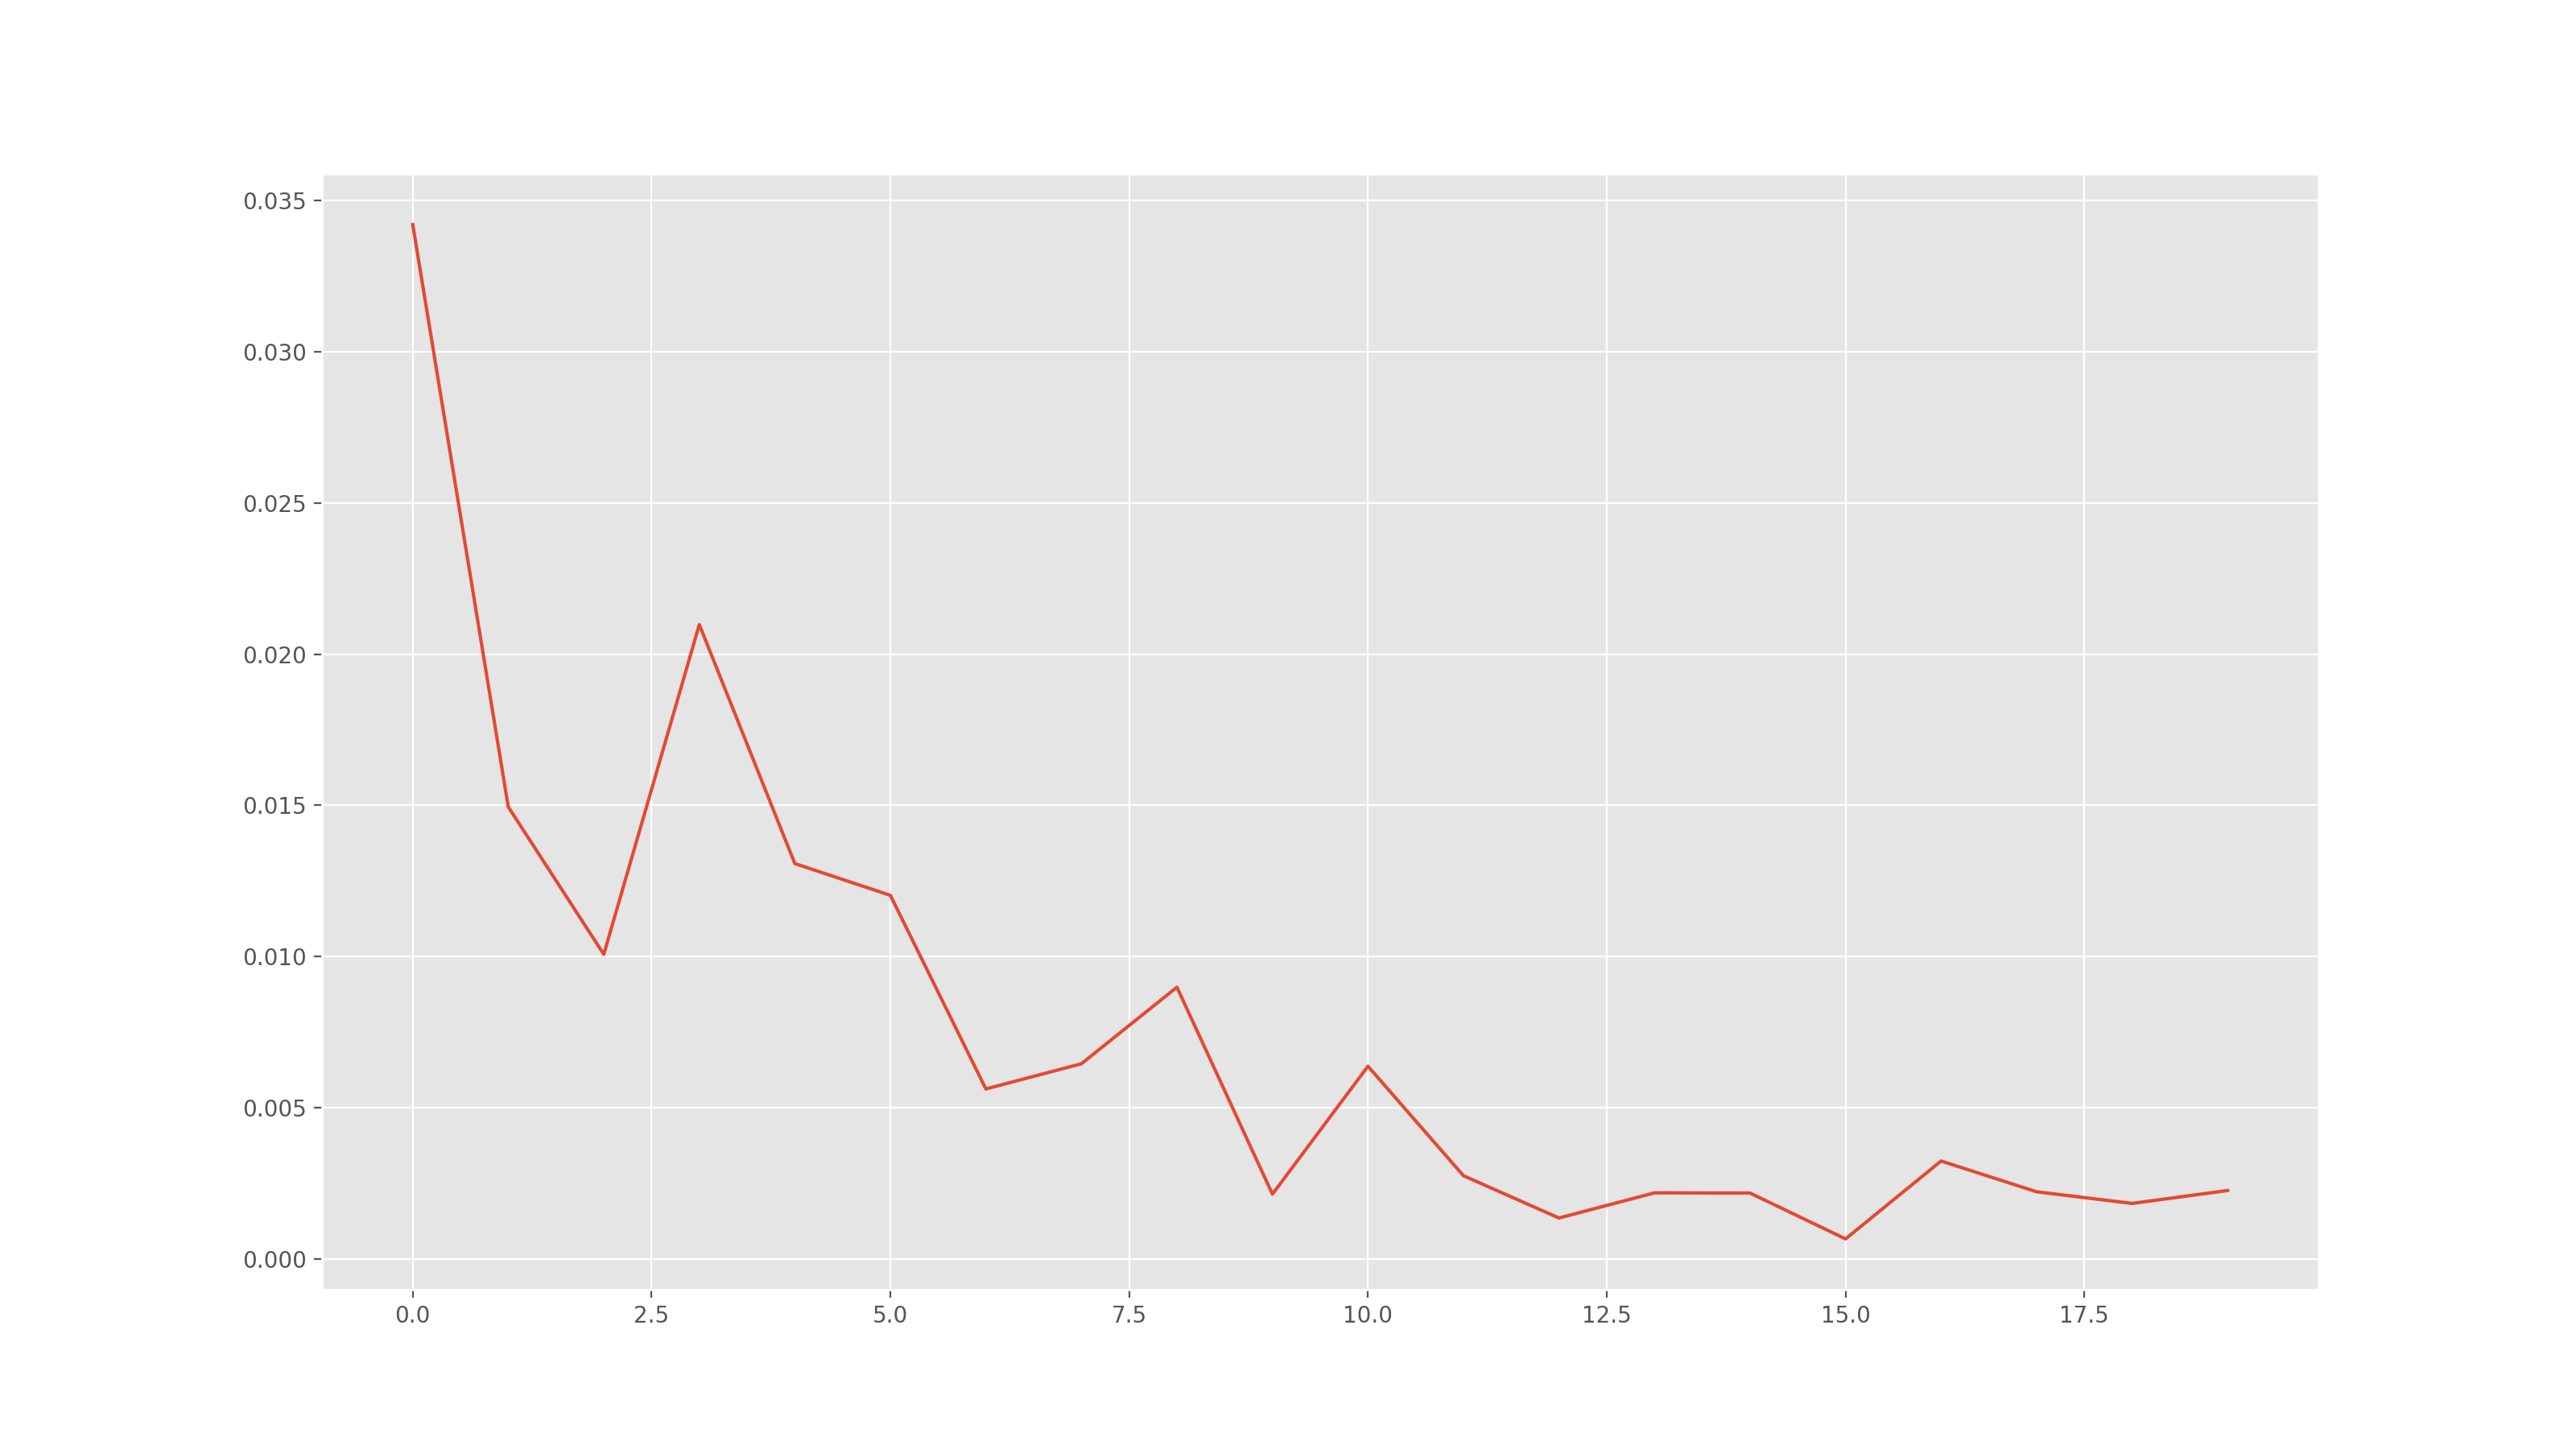

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Training done in 331.087612 mins


In [35]:
start_time = time.time()
entropy = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(epochs):
    counter = 0
    if training_done:
        break
    for batch_X, batch_Y in readImages(data_info, batch_size=10):
        batch_X = preprocessData(batch_X)
        train_data = {x: batch_X, y_actual: batch_Y}
        
        # Training Step
        session.run(optimizer, feed_dict=train_data)
        
        entropy_value = session.run(cross_entropy, feed_dict=train_data)
        
#         if counter % 500 == 0:
#             clear_output(wait=True)
#             display('Iteration '+str(i)+ ' Batch counter ' + str(counter) + ' Entropy: '+ str(entropy_value))
#         counter += 1
        
    if not np.isnan(entropy_value):
        entropy.append(entropy_value)
        draw(fig, ax, entropy)
        print('Iteration '+str(i))
        
print("Training done in %f mins"%((time.time() - start_time)/60))

In [36]:
model = os.path.join(os.getcwd(), 'model')
if not os.path.exists(model):
    os.makedirs(model)

In [37]:
flag = True
if flag or raw_input('Do you want to save this model ? (y/n)').strip() == 'y':
    saver = tf.train.Saver()
    save_path = saver.save(session, os.path.join(model, "model.ckpt"))
    print("Model saved in path: %s" % save_path)

Model saved in path: /home/amit/notebooks/self-driving/model/model.ckpt
